In [4]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, RawScoresOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
from pytorch_grad_cam.utils.image import scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from model import *
from module import * 
from dataloader_comma import *
from torch.utils.data import DataLoader
from collections import OrderedDict
import cv2
import numpy as np
import torch
import ttach as tta
from typing import Callable, List, Tuple
import imageio
import os
from torchvision.transforms import Compose, Normalize, ToTensor
import matplotlib.pyplot as plt

/home/jessica/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


This is a notbook to show the gradient of the model inside the rendered images

In [5]:
class UnNormalize(object):
    '''Since the dataloader returns normalized images, we migth need to unnormalize them again'''
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [6]:
def rename_state_dict_keys(state_dict):
    '''function to match the state dict weights, in case they were saved with "model." prefix'''
    new_state_dict = OrderedDict()
    for key, value in state_dict.items():
        new_key = key.replace("model.", "")
        new_state_dict[new_key] = value

    return new_state_dict

GradCAM Logic

In [7]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x, y, z, a):
        self.gradients = []
        self.activations = []
        return self.model(x, y, z, a)

    def release(self):
        for handle in self.handles:
            handle.remove()

In [8]:
class BaseCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.to(device="cuda:2")
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        input_tensor_dist: torch.Tensor,
                        input_tensor_angle: torch.Tensor,
                        input_tensor_vego: torch.Tensor,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        raise Exception("Not Implemented")

    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      input_tensor_dist: torch.Tensor,
                      input_tensor_angle: torch.Tensor,
                      input_tensor_vego: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:

        weights = self.get_cam_weights(input_tensor,
                                        input_tensor_dist,
                                        input_tensor_angle,
                                        input_tensor_vego,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: torch.Tensor,
                input_tensor_dist: torch.Tensor,
                input_tensor_angle: torch.Tensor,
                input_tensor_vego: torch.Tensor,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        if self.cuda:
            input_tensor = input_tensor.to(device="cuda:2")

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)
            input_tensor_dist = torch.autograd.Variable(input_tensor_dist,
                                                   requires_grad=True)
            input_tensor_angle = torch.autograd.Variable(input_tensor_angle,
                                                   requires_grad=True)
            input_tensor_vego = torch.autograd.Variable(input_tensor_vego,
                                                   requires_grad=True)

        outputs = self.activations_and_grads(input_tensor, input_tensor_dist, input_tensor_angle, input_tensor_vego)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(
                category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            outputs = outputs.squeeze()

            loss = sum([target(output)
                       for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   input_tensor_dist,
                                                   input_tensor_angle,
                                                   input_tensor_vego,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: torch.Tensor) -> Tuple[int, int]:
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor,
            input_tensor_dist: torch.Tensor,
            input_tensor_angle: torch.Tensor,
            input_tensor_vego: torch.Tensor,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                    input_tensor_dist,
                                    input_tensor_angle,
                                    input_tensor_vego,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(
            self,
            cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       input_tensor_dist: torch.Tensor,
                                        input_tensor_angle: torch.Tensor,
                                        input_tensor_vego: torch.Tensor,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                                input_tensor_dist,
                                input_tensor_angle,
                                input_tensor_vego,
                               targets,
                               eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: torch.Tensor,
                 input_tensor_dist: torch.Tensor,
                input_tensor_angle: torch.Tensor,
                input_tensor_vego: torch.Tensor,
                 targets: List[torch.nn.Module] = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, input_tensor_dist,
                                input_tensor_angle,
                                input_tensor_vego, targets, eigen_smooth)

        return self.forward(input_tensor,
                            input_tensor_dist,
                            input_tensor_angle,
                            input_tensor_vego,
                            targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

In [9]:
class GradCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        input_tensor_dist,
                        input_tensor_angle,
                        input_tensor_vego,
                        target_layer,
                        target_category,
                        activations,
                        grads):
        return np.mean(grads, axis=(2, 3))

In [10]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

Load model

In [58]:
task = 'distance'
model = VTN(multitask=task, backbone="resnet")

#set checkpoint path
PATH = '/home/jessica/personalized_driving_toyota/checkpoints_comma_multitask/lightning_logs/version_23/checkpoints/epoch=31-step=2464.ckpt'#'/home/jessica/personalized_driving_toyota/checkpoints_comma_distance/lightning_logs/version_37/checkpoints/epoch=39-step=1080.ckpt'
#PATH = '/home/jessica/personalized_driving_toyota/checkpoints_comma_angle/lightning_logs/version_11/checkpoints/epoch=32-step=891.ckpt'

#load model checkpoint 
checkpoint = torch.load(PATH, map_location="cpu")
checkpoint = rename_state_dict_keys(checkpoint['state_dict'])
model.load_state_dict(checkpoint)
#move model to GPU if desired 
model = model#.to(device="cuda:2")

Load data

In [ ]:
ds = CommaDataset(dataset_type="test", multitask="distance")
dl = DataLoader(ds, batch_size=10, num_workers=4)
elem = next(iter(dl))
meta, image_array, vego, dist, angl= elem
idx = 9 #set an index from the current batch to examine

input_tensor = image_array.float()[idx].unsqueeze(0) # Create an input tensor image for your model..
input_tensor_angle = angl.float()[idx].unsqueeze(0)
input_tensor_dist = dist.float()[idx].unsqueeze(0)
input_tensor_vego = vego.float()[idx].unsqueeze(0)

In [59]:
'''mn = 120
idx_best = None
for idx, i in enumerate(dist):
    if i.mean() <= mn:
        mn = i.mean()
        idx_best = idx
idx_best, mn'''

'mn = 120\nidx_best = None\nfor idx, i in enumerate(dist):\n    if i.mean() <= mn:\n        mn = i.mean()\n        idx_best = idx\nidx_best, mn'

In [60]:
target_layers = [model.backbone[7][-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

targets = [RawScoresOutputTarget()]
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [61]:
grayscale_cam_1 = cam(input_tensor=input_tensor,input_tensor_dist=input_tensor_dist, input_tensor_angle=input_tensor_angle,input_tensor_vego=input_tensor_vego,targets=targets)
sample = 9
path_save = f'./img_{task}/'
images = []
for i in range(grayscale_cam_1.shape[0]):
    grayscale_cam = grayscale_cam_1[i, :]
    im = np.array((unorm(input_tensor[0][i])).cpu().permute(1,2,0))
    visualization = show_cam_on_image(im, grayscale_cam, use_rgb=True)
    images.append(visualization)

In [ ]:

imageio.mimsave(f'{path_save}/{sample}.gif', images)

In [88]:
import pandas as pd

In [117]:
df = pd.read_csv('/home/jessica/personalized_driving_toyota/checkpoints_comma_distance/lightning_logs/version_40/dist.csv')

In [140]:
df.err.tolist()

[1.2145614624023366,
 1.7470169067382812,
 1.3489151000976562,
 1.8600959777832031,
 1.7481575012207031,
 1.995330810546875,
 0.3920783996582031,
 0.8639106750488281,
 0.9206428527832031,
 -0.7106666564941406,
 -0.6347541809082031,
 1.5383796691894531,
 0.46102142333983664,
 1.8748664855957031,
 1.743927001953118,
 3.152507781982422,
 2.4361534118652344,
 2.8348121643066406,
 2.4831886291503835,
 2.4814300537109375,
 1.69708251953125,
 0.5595588684082031,
 -0.8695449829101562,
 -1.7194061279296946,
 -2.086681365966797,
 -3.922290802001953,
 -3.8114013671875,
 -3.785400390625007,
 -2.902080535888672,
 -3.644329071044922,
 -2.86993408203125,
 -3.196758270263672,
 -1.767852783203125,
 -1.3274765014648438,
 -2.0670738220214915,
 0.7120857238769531,
 1.4728889465332031,
 1.5974349975585938,
 3.3567390441894602,
 4.163597106933594,
 3.8561477661132812,
 3.54345703125,
 4.446865081787109,
 3.705463409423828,
 3.7344436645507812,
 3.7513389587402344,
 3.1592025756835938,
 3.6751937866210938,
 

In [118]:
df.columns = ['preds', 'targets']

In [119]:
df = df[df['targets'] != 0]

In [133]:
df['err'] = df['targets'] - df['preds']

In [134]:
ten = df[df['targets'] < 10]
six = df[df['targets'] > 60]

In [135]:
twen = df[(df['targets'] > 10 & (df['targets'] < 20))]
four = df[(df['targets'] > 20 & (df['targets'] < 40))]
fift = df[(df['targets'] > 40 & (df['targets'] < 60))]


In [136]:
ndf = {}
ndf["<10"] = ten['err'].tolist()
ndf["10-20"] = twen['err'].tolist()
ndf["20-40"] = four['err'].tolist()
ndf["40-60"] = fift['err'].tolist()
ndf[">60"] = six['err'].tolist()

[Text(1, 0, '<10'),
 Text(2, 0, '10-20'),
 Text(3, 0, '20-40'),
 Text(4, 0, '40-60'),
 Text(5, 0, '>60')]

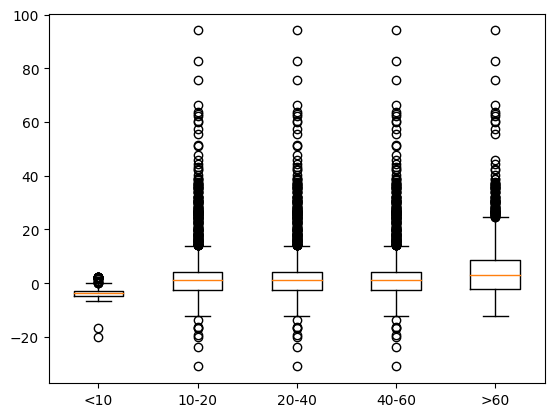

In [137]:
my_dict = ndf

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())